# Chapter 1 - Basics of Diffusion

## What is Diffusion?

A diffusion model is a probabilistic generative model that generates data by using a series of noising and denoising process. 

There are 2 steps here:
<ul>
<li>Forward process: Add noise to data over a series of timesteps. Basically, take an image, keep adding noise progressively over it to convert the image to pure noise.</li>
<li>Reverse process: Take pure noise, remove noise progressively from the noise to create/generate the original data from noise.</li>
</ul>

The forward process is fairly easy. You just take an image, add gaussian noise to it. The reverse process is hard and that is what we want our model to learn

### Forward Process (Noising)

The forward process is all about taking data (images in our case), and adding noise to it. 

We have our image $x$. We add noise to it over $T$ timesteps, meaning we keep adding noise to the image slowly for $T$ timesteps, allowing our image to slowly, gradually turn into pure noise.

We'll start with a single step. A single step here is taking an image, and adding some noise to it. <br>

Let's look at an example of adding noise to an image from the MNIST dataset using Pytorch.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

Let's load the MNIST dataset from Pytorch's datasets class.

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

We'll now pull out a random image from the Pytorch dataset.

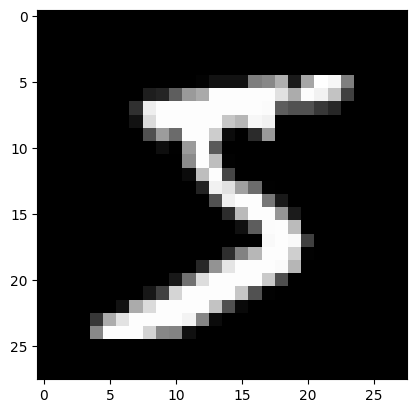

In [3]:
image = mnist_data[0][0]  # Take the first image (shape: [1, 28, 28])
plt.imshow(image.squeeze(0), cmap='gray') #tensor.squeeze converts the image from a shape of [1, 28, 28] to [28, 28]

Now finally, let's generate some noise and add it to the image.

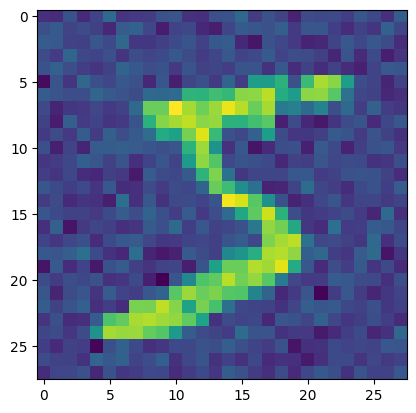

In [4]:
noise = torch.randn_like(image) * 0.1
noisy_image = image + noise
plt.imshow(noisy_image.squeeze(0))

Let's formalize this. 

We have $x_0$ which is our initial original image. $x_1$ is the image we get by adding noise to $x_0$. $x_2$ is the image we get by adding noise to $x_1$, and so on. We can represent the image we get after adding noise $t$ times to $x_0$ progressively as $x_t$. 

So, effectively, $x_t$ is just $x_{t-1}$ minus some noise. Let's put it a bit formally: 
$$x_t = x_{t-1} + \epsilon$$ 
$$\epsilon \sim \mathcal{N}(0, I)$$

In plain English, the first equation tells us that $x_t$ is just some noise added to $x_{t-1}$. The second equation is just indicating that $\epsilon$ is just a noise that we sample from a normal distribution. The 0 represents the mean, and the $I$ is the covariance matrix with 1s on the diagonal indicating that the noise added to each pixel is independent of each other.  

So, now, let's see in code, how we can add noise to an image progressively over multiple steps. We'll also look at how these images look like after different timesteps. 

In [5]:
def add_noise_simple(image, T):
    """
    Repeatedly add Gaussian noise to an image over T timesteps.
    """
    noisy_images = []
    current_image = image.clone()  # Clone to avoid modifying the original image
    for t in range(T):
        noise = torch.randn_like(image) * 0.1  # Generate Gaussian noise
        current_image += noise  # Add noise to the image
        noisy_images.append(torch.clamp(current_image, 0, 1))  # Keep pixel values in [0, 1]
    return noisy_images

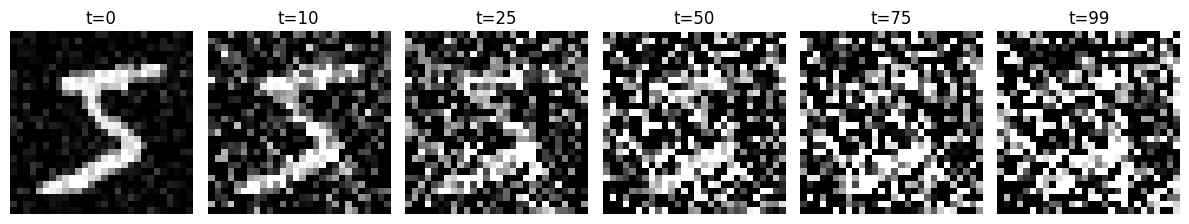

In [6]:
T = 100  # Number of timesteps
noisy_images = add_noise_simple(image, T)
# Visualize original and noisy images at different timesteps
timesteps_to_show = [0, 10, 25, 50, 75, T-1]
plt.figure(figsize=(12, 6))
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i + 1)
    plt.imshow(noisy_images[t].squeeze().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

So, that was pretty straight forward. We take an image, generate some gaussian noise, add it to an image, generate a new noisy image which still represents the original image, but a bit more noisy. Then, we take the noisy image, add noise to it again make it more noisy. 

We iteratively do this for $T$ timesteps, eventually getting to a point where at timestep $T$ (in the above example it is 100), the resultant image is just pure noise, one that looks completely irrelevant to the original image. 

There are a few issues with the above logic. <br>

One, we can see that by the time we get to the 75th image, we almost completely lose the structure. We don't want that to happen. We want to gradually remove the noise because we also want it easier for the model to understand how much noise has been added. So, we would like to add very very little noise for a large number of timesteps, like 1000.

The other issue is that everytime we want to calculate the noise added at Timestep $t$, we have to iterate $t$ times. It would be more convenient to just have a simple formula to calculate it in a single step i.e, go from $x_0$, to $x_t$ in one step directly. We'll first start with solving this problem first, before we get into solving the problem of gradually adding noise. 

To get to this, we need to make slight modifications into how we approach this. 

Let's get a bit formal to understand this. 

Now, we'll start formalizing the process of how we go from $x_{t-1}$ to $x_t$. Look at the following equation: $$x_t = \sqrt{{\alpha}_t} \, x_{t-1} + \sqrt{1 - {\alpha}_t} \, \epsilon$$
where, <br>
<ul>
    <li>${\alpha}_t$ controls how much portion of the previous image $x_{t-1}$ we retain </li>
    <li>$(1 - {\alpha}_t)$ tells how much of the sampled noise is taken. So, effectively, we are controlling how much of the original image we are retaining and how much of the noise we are taking into account when generated $x_t$. </li>
</ul>


So, let's break it down into plain English. Also let's ignore the square roots for now (I'll explain why we add that later). Let's look at the formula without square roots: $$x_t = {\alpha}_t \, x_{t-1} + 1 - {\alpha}_t \, \epsilon$$ <br>
<br>
${\alpha}_t$ is a number between 0 and 1. At $t=0$, ${\alpha}_0 = 1$.

So let's say in the first timestep, we want to retain 99% of the original image ($x_0$) and only want 1% of it to have noise, then we'll set ${\alpha}_1 = 0.99$

Let's look at this works with the above formula. <br>

So at t=1, we will set ${\alpha}_1 = 0.99$. In that case $1 - {\alpha}_1$ will be 0.01. Substituting those two terms in the above equation for $x_t$, in our case then, 

$$x_1 = {\alpha}_1 \, x_{0} + ({1 - {\alpha}_1}) \, \epsilon$$ <br> $$x_1 = 0.99 * x_{0} + (1-0.99) * \epsilon$$ <br> $$x_1 = x_{t-1} + 0.01 * \epsilon$$

The above equation points that we will retain 99% of the original image, and add 1% of the generated noise to the original image, to create a slightly noisy image. 


Let's look at this as code

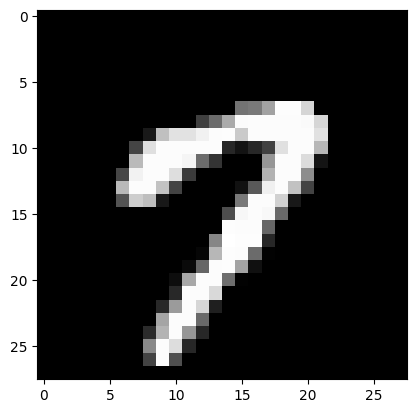

In [7]:
image = mnist_data[15][0]  # Take the first image (shape: [1, 28, 28])
plt.imshow(image.squeeze(0), cmap='gray') #tensor.squeeze converts the image from a shape of [1, 28, 28] to [28, 28]

We'll define a function that takes in the image and a value for alpha and calculates a resulting image accordingly. 

In [8]:
def add_noise_with_alpha(image, alpha):
    noise = torch.randn_like(image)
    noisy_image = (alpha * image) + ((1-alpha) * noise)
    return noisy_image

In this case, let's have ${\alpha}_t$ as 0.9, meaning we want to retain 90% of the original image, and the rest will be noise. 

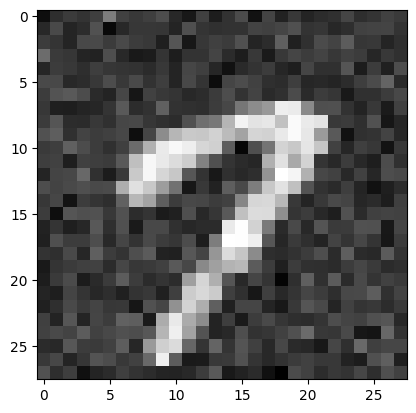

In [9]:
noisy_image = add_noise_with_alpha(image, alpha=0.9)
plt.imshow(noisy_image.squeeze(0), cmap='gray')

As mentioned before, when $t=1$, ${\alpha}_t$ will be close to 1, so when you multiply ${\alpha}_0$ with $x_0$, then the resultant $x_1$ remains the same, or nearly the same as $x_0$. <br>
Also, when $t=1$, $(1 - \bar{\alpha}_t)$ will be a very very low value, meaning when it is multiplied with the noise $\epsilon$, the value of it will be very very low that no noise or very little noise will be added. As a consequence, most of the image will be retained. 

So, do this iteratively, we can set a constant ${\alpha}_t$. Maybe we can set it at 0.99. So, at each step, we set the ${\alpha}_t$ at 0.99. 

For let's do this for three steps. 

$$x_1 = (0.99 * x_0) + (0.01 * \epsilon)$$ 

Then, x_2 will be dependent on $x_1$ and the same $\alpha$. Same goes for $x_3$.

$$x_2 = (0.99 * x_1) + (0.01 * \epsilon)$$
$$x_3 = (0.99 * x_2) + (0.01 * \epsilon)$$
$$x_4 = (0.99 * x_3) + (0.01 * \epsilon)$$

Let look at this as code.

In [10]:
x_0 = mnist_data[15][0]
noisy_images = [x_0]
current_image = x_0
for i in range(1, 5):
    print(f'Generating x_{i}')
    current_image = add_noise_with_alpha(current_image, alpha=0.99)
    noisy_images.append(current_image)


Generating x_1
Generating x_2
Generating x_3
Generating x_4


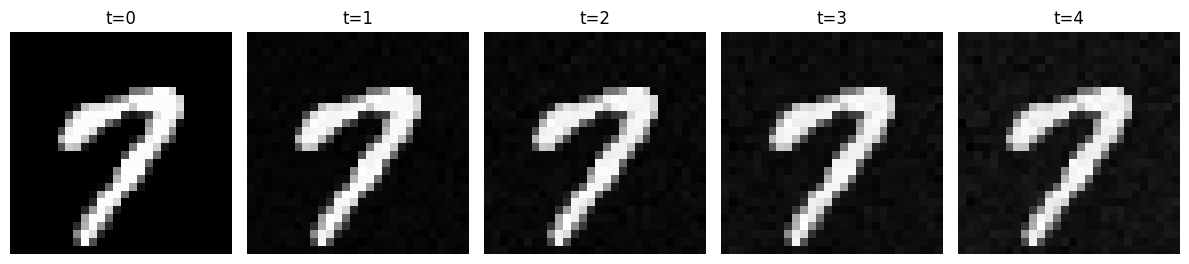

In [11]:
plt.figure(figsize=(12, 5))
timesteps_to_show = [0, 1, 2, 3, 4]
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i + 1)
    plt.imshow(noisy_images[t].squeeze().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Now, let's go and see how to go from $x_0$ to $x_t$, let's assume $x_2$. 

Let's take our previous example and go step by step from $x_0$ to $x_2$.
$$\alpha = 0.99$$
$$x_1 = (0.99 * x_0) + (0.01 * \epsilon)$$ 
$$x_2 = (0.99 * x_1) + (0.01 * \epsilon)$$

Let's substitute the equation of $x_1$ in $x_2$. 

$$x_2 = (0.99 * (0.99 * x_0)) + (0.99 * (0.99 * \epsilon)$$ 
$$x_2 = (0.99^2 * x_0) + (0.99^2 * \epsilon)$$
$$x_2 = ({\alpha}^2 * x_0) + ({\alpha}^2 * \epsilon)$$

This gives us one thing. If we want to calculate $x_2$, we multiply $\alpha$ twice with itself. For $x_3$ it'll be ${\alpha}^3$ and so on. 

So, let's introduce $\bar{\alpha}_t$.

$$\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$$

So, for $t=2$,
$$\bar{\alpha}_2 = \prod_{i=1}^{2} \alpha_i$$
$$\bar{\alpha}_t = \alpha_1 * \alpha_2$$
And since in our case, we can constant alpha, 
$$\bar{\alpha}_t = \alpha^2$$

Let's define a equation that uses this to go from $x_0$ to $x_t$,
$$x_t = {\bar{\alpha}_t} \, x_0 + {1 - \bar{\alpha}_t} \, \epsilon$$

So, if $t=2$, then, 
$$x_2 = {\bar{\alpha}_2} \, x_0 + {1 - \bar{\alpha}_2} \, \epsilon$$
$$x_2 = {\alpha^2} \, x_0 + {1 - {\alpha}^2} \, \epsilon$$


There you go. So, we now have a simple formula that allows us to directly go from $x_0$ to $x_t$. 


Mathematically, $$q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \alpha_t x_{t-1}, (1-\alpha_t)\mathbf{I})$$
where, 
<ul>
<li>$x_t$ is the image after adding noise at timestep t</li>
<li>$\alpha_t$ controls how much noise is added to the image at each timestep</li>
<li>$\mathcal{N}$ represents the gaussian distribution</li>
<li>$I$ is means the noise added to each pixel is independent of each other</li>
    
</ul>

In plain English, $q(x_t \mid x_{t-1})$ represents the conditional probability of getting $x_t$ given the image from the previous step, $x_t-1$. In other words how likely is it to get noisy image $x_t$ from the previous image $x_t-1$.

But, why do we even need this equation. Can't we simply say $$x_t = x_{t-1}+ {N}$$

where, 
<ul>
    <li>$x_t$ is the image after adding noise at timestep t.</li>
    <li>${N}$ is the gaussian noise.</li>
</ul>

This is much more simpler, isn't it? Well it is, and practically that is what we do. But, what $q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \alpha_t x_{t-1}, (1-\alpha_t)\mathbf{I})$ represents is that, we are trying to imply that the image $x_t$ is directly drawn from a random set of images from a probability distribution. 

Let's try putting the above information in a different way. 

Let's assume that you have a bunch of images in a folder. All the images in the folder forms a probability distribution. 

In our case, there are millions of ways to add noise to the image $x_{t-1}$ to get the image $x_t$. So, we can generate a folder containing millions of images by adding various noise sampled from a gaussian distribution to the original image $x_{t_1}$. 

So, let's arrive at a more intuitive equation. Mathematically, let's assume $\mathcal{N}$ is the distribution of all possible images that can be formed, which could be billions of images. But, if our starting image is $x_{t-1}$, then there is only a few millions of images from the given distribution. So, mathemtically, $$q(x_t \mid x_{t-1}) = \mathcal{N}(x_{t-1};\mathcal{u}, \mathcal{sigma})$$ 

means, the image $x_t$ itself is sampled from a distribution of all images, but its structure is dependent on its previous image $x_t$ and a gaussian noise matrix with mean $\mathcal{u}$ and variance $\mathcal{sigma}$.

So, what we are trying to represent is that, given that you add a specific noise ${N}$  to $x_{t-1}$, what is the probability of getting the image that you just got, given that there are a million other noisy images you could have generated. 

This ties back to why we refer to diffusion models as probabilistic models. Each image that we derive in both forward and backward process is taken from a probability distribution.